## REMD Folding simulation of the TRP Cage protein
The previous folding experiment (folding study with heavy hydrogen) for the trp cage have not yieled the correct folded structure so far. They have run for approximately 15uS of simulation time which is roughly 3x the time that the structures are expected to fold in reality.

The probable cause for the failure to fold is that the OPLS/AA force field used results in a higher than physical melting temperature. The protein should melt at around 340K according to experiment, however some papers have shown that the using the OPLS/AA force field the melting temperature is more like 425K.

This results in the simulation getting stuck in local minima and not progressing on to explore the whole confirmation space.

---
In this experiment we will use Replica Exchange MD to attempt to sample both high and low temperature confirmations to get the protein unstuck.

In [30]:
# Preabmle to import our helper scripts and set up environment for a Gromacs simulation

import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from helpers.GromacsHelpers import *
%matplotlib inline

We will start with the partially folded trp cage from the previous study rather than the linear protein as the partially folded structure will allow us to fit the protein in a smaller box with less water required to solvate it. This will in turn allow for faster simulations.

We will also use heavy hydrogen to speed up the simulation time a little.

In [32]:
!scp psol3692@hpc.sydney.edu.au:/project/MDPF/trp_cage/folding_study/md_1_0.{gro,tpr} .

md_1_0.gro                                    100% 2746KB   2.7MB/s   00:00    
md_1_0.tpr                                    100% 1211KB   1.2MB/s   00:00    


In [33]:
%%bash
module load gromacs

gmx trjconv -f md_1_0.gro -s md_1_0.tpr -pbc mol -center true -o md_1_0.pdb <<< $'1\n1\n' 

Select group for centering
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'


                     :-) GROMACS - gmx trjconv, 2016.2 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra    Gerrit Groenhof  
 Christoph Junghans   Anca Hamuraru    Vincent Hindriksen Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff    Erik Marklund   
   Teemu Murtola       Szilard Pall       Sander Pronk      Roland Schulz   
  Alexey Shvetsov     Michael Shirts     Alfons Sijbers     Peter Tieleman  
  Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University, Stockholm University

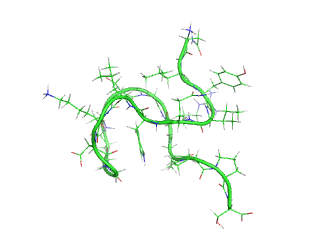

In [34]:
pymolPlotStructure("md_1_0.pdb")

In [36]:
%%bash
module load gromacs

gmx pdb2gmx -f md_1_0.pdb -o trp_cage_processed.gro -ignh -heavyh -water spce -ff oplsaa 2>/dev/null


Using the Oplsaa force field in directory oplsaa.ff

Reading md_1_0.pdb...
Read 'Protein in water t=   0.00000', 154 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 ' '    20    154  

Reading residue database... (oplsaa)
Processing chain 1 (154 atoms, 20 residues)
Identified residue ASN2 as a starting terminus.
Identified residue SER21 as a ending terminus.
Start terminus ASN-2: NH3+
End terminus SER-21: COO-
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: md_1_0.pdb.
The Oplsaa force field and the spce water model are used.
		--------- ETON ESAELP ------------


In [37]:
%%bash
module load gromacs

gmx editconf -f trp_cage_processed.gro -o trp_cage_newbox.gro -c -d 1.0 -bt cubic 2>/dev/null
gmx solvate -cp trp_cage_newbox.gro -cs spc216.gro -o trp_cage_solv.gro -p topol.top 2>/dev/null

Read 304 atoms
Volume: 413.46 nm^3, corresponds to roughly 186000 electrons
No velocities found
    system size :  2.007  2.181  2.174 (nm)
    diameter    :  2.581               (nm)
    center      :  3.657  3.982  3.688 (nm)
    box vectors :  7.450  7.450  7.450 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 413.46               (nm^3)
    shift       : -1.366 -1.691 -1.397 (nm)
new center      :  2.290  2.290  2.290 (nm)
new box vectors :  4.581  4.581  4.581 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  96.13               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may b

In [6]:
%%file em.mdp
; Parameters describing what to do, when to stop and what to save
integrator  = steep     ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0    ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps      = 50000     ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions (yes/no)

Writing em.mdp


In [38]:
%%bash
module load gromacs

gmx grompp -f em.mdp -c trp_cage_solv.gro -p topol.top -o ions.tpr 2>/dev/null
gmx genion -s ions.tpr -o trp_cage_solv_ions.gro -p topol.top -pname NA -nname CL -nn 1 <<< $'13\n' 2>/dev/null

Analysing residue names:
There are:    20    Protein residues
There are:  3043      Water residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.115 0.115 0.115
This run will generate roughly 1 Mb of data
Will try to add 0 NA ions and 1 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 1 solute molecules in topology file (topol.top)  by 0 NA and 1 CL ions.


In [39]:
%%bash
module load gromacs

gmx grompp -f em.mdp -c trp_cage_solv_ions.gro -p topol.top -o em.tpr 2> /dev/null
gmx mdrun -v -deffnm em

Analysing residue names:
There are:    20    Protein residues
There are:  3042      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.115 0.115 0.115
This run will generate roughly 1 Mb of data


In [40]:
%%bash
module load gromacs

gmx energy -f em.edr -o em.xvg <<< $'10\n' 2>/dev/null


Statistics over 282 steps [ 0.0000 through 281.0000 ps ], 1 data sets
All statistics are over 223 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -146100       4400    12014.7     -28846  (kJ/mol)


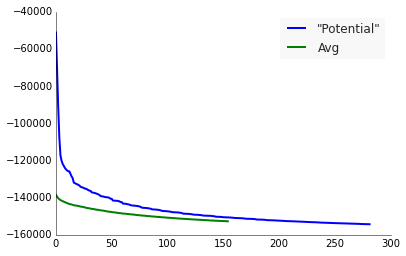

In [41]:
plotFigure("em.xvg")

In [42]:
%%file nvt.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 20000     ; 2 * 20000 = 40 ps
dt          = 0.006     ; 6 fs

; Output control
nstxout     = 500       ; save coordinates every 1.0 ps
nstvout     = 500       ; save velocities every 1.0 ps
nstenergy   = 500       ; save energies every 1.0 ps
nstlog      = 500       ; update log file every 1.0 ps

; Bond parameters
continuation            = no        ; first dynamics run
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl      = no        ; no pressure coupling in NVT

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = yes       ; assign velocities from Maxwell distribution
gen_temp    = 325       ; temperature for Maxwell distribution
gen_seed    = -1        ; generate a random seed

Overwriting nvt.mdp


In [43]:
%%bash
module load gromacs

gmx grompp -f nvt.mdp -c em.gro -p topol.top -o nvt.tpr 2>/dev/null
gmx mdrun -v -deffnm nvt

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Analysing residue names:
There are:    20    Protein residues
There are:  3042      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 325 K
Calculated rlist for 1x1 atom pair-list as 1.013 nm, buffer size 0.013 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.143 0.143 0.143
This run will generate roughly 10 Mb of data


In [44]:
%%bash
module load gromacs

gmx energy -f nvt.edr -o nvt_temp.xvg <<< $'15\n' 2>/dev/null


Statistics over 20001 steps [ 0.0000 through 40.0000 ps ], 1 data sets
All statistics are over 201 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 324.376       0.25    4.09634    1.41663  (K)


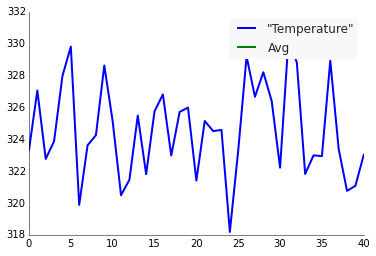

In [45]:
plotFigure("nvt_temp.xvg")

In [46]:
%%file npt.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 20000     ; 6 * 20000 = 120 ps
dt          = 0.006     ; 6 fs

; Output control
nstxout     = 200       ; save coordinates every 1.2 ps
nstvout     = 200       ; save velocities every 1.2 ps
nstenergy   = 200       ; save energies every 1.2 ps
nstlog      = 200       ; update log file every 1.2 ps

; Bond parameters
continuation            = yes       ; restarting acter NVT
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is on
pcoupl              = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype          = isotropic             ; uniform scaling of box vectors
tau_p               = 2.0                   ; time constant, in ps
ref_p               = 1.0                   ; reference pressure, in bar
compressibility     = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling    = com

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = no       ; Velocity generation is off

Overwriting npt.mdp


In [47]:
%%bash
module load gromacs

gmx grompp -f npt.mdp -c nvt.gro -t nvt.cpt -p topol.top -o npt.tpr 2>/dev/null
gmx mdrun -v -deffnm npt

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Analysing residue names:
There are:    20    Protein residues
There are:  3042      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 325 K
Calculated rlist for 1x1 atom pair-list as 1.068 nm, buffer size 0.068 nm
Set rlist, assuming 4x4 atom pair-list, to 1.016 nm, buffer size 0.016 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.143 0.143 0.143
This run will generate roughly 23 Mb of data


In [48]:
%%bash
module load gromacs

gmx energy -f npt.edr -o npt_pres.xvg <<< $'16\n' 2>/dev/null
gmx energy -f npt.edr -o npt_dens.xvg <<< $'22\n' 2>/dev/null


Statistics over 20001 steps [ 0.0000 through 120.0000 ps ], 1 data sets
All statistics are over 201 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                    24.6102         22    293.923   -125.432  (bar)

Statistics over 20001 steps [ 0.0000 through 120.0000 ps ], 1 data sets
All statistics are over 201 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     995.265       0.39     5.3344   -1.30603  (kg/m^3)


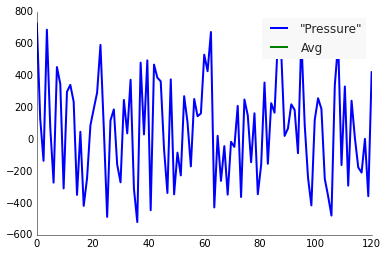

In [49]:
plotFigure("npt_pres.xvg")

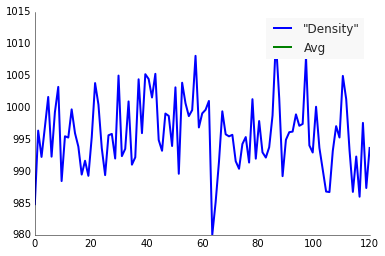

In [50]:
plotFigure("npt_dens.xvg")

We should now have an equilibrated system ready to perform a REMD run on. For REMD we need to set up a series of parallel simulations running at different temperatures. The temperature series that we will use was calculates at http://folding.bmc.uu.se/remd/ and is 300.00, 303.15, 306.33, 309.52, 312.75, 316.00, 319.26, 322.57, 325.91, 329.27, 332.67, 336.10, 339.55, 343.03, 346.53, 350.08, 353.65, 357.25, 360.88, 364.54, 368.23, 371.96, 375.71, 379.50, 383.31, 387.17, 391.06, 394.98, 398.93, 402.91, 406.93, 410.98, 415.07, 419.19, 423.35, 427.55, 431.78, 436.05, 440.35, 444.69, 449.07, 453.48, 457.93, 462.42, 466.95, 471.52, 476.12, 480.77, 485.45, 490.18, 494.95, 499.76, 504.61, 509.49, 514.42, 519.40, 524.42, 529.47, 534.58, 539.72, 544.92, 550.15, 555.45, 560.78, 566.15, 571.57, 577.03, 582.55, 588.11, 593.72, 599.39, 605.09

To start with we need to create a folder (or file) for each temperature and then run equilibration runs of approx 100ps for each temperature.

In [51]:
!mkdir stage1

In [52]:
cd stage1

/home/pauls/honours/notebooks/computational/trp_cage/remd_folding_study/stage1


In [130]:
%%file equil.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 25000     ; 4 * 25000 = 100 ps
dt          = 0.004     ; 4 fs

; Output control
nstxout     = 250       ; save coordinates every 1.0 ps
nstvout     = 250       ; save velocities every 1.0 ps
nstcalcenergy = 50      
nstenergy   = 250       ; save energies every 1.0 ps
nstlog      = 250       ; update log file every 1.0 ps

; Bond parameters
continuation            = yes       ; restarting acter NVT
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = REF_TEMP REF_TEMP              ; reference temperature, one for each group, in K

; Pressure coupling is on
pcoupl              = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype          = isotropic             ; uniform scaling of box vectors
tau_p               = 2.0                   ; time constant, in ps
ref_p               = 1.0                   ; reference pressure, in bar
compressibility     = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling    = com

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = no       ; Velocity generation is off

Overwriting equil.mdp


generate all of the mdp files each with their own unique ref_t

In [132]:
%%bash

temps="300.00, 303.15, 306.33, 309.52, 312.75, 316.00, 319.26, 322.57, 325.91, 329.27, 332.67, 336.10, 339.55, 343.03, 346.53, 350.08, 353.65, 357.25, 360.88, 364.54, 368.23, 371.96, 375.71, 379.50, 383.31, 387.17, 391.06, 394.98, 398.93, 402.91, 406.93, 410.98, 415.07, 419.19, 423.35, 427.55, 431.78, 436.05, 440.35, 444.69, 449.07, 453.48, 457.93, 462.42, 466.95, 471.52, 476.12, 480.77, 485.45, 490.18, 494.95, 499.76, 504.61, 509.49, 514.42, 519.40, 524.42, 529.47, 534.58, 539.72, 544.92, 550.15, 555.45, 560.78, 566.15, 571.57, 577.03, 582.55, 588.11, 593.72, 599.39, 605.09"
temp_array=($(echo $temps | sed "s/,//g"))
for ((i = 0; i < ${#temp_array[@]}; ++i)); do
    # call your procedure/other scripts here below
    idx=$i
    temp=${temp_array[$i]}
    sed "s/REF_TEMP/$temp/g" equil.mdp > "equil$idx.mdp"
done

Generate all of the tpr files required to do a mdrun

In [133]:
%%bash
module load gromacs

for i in {0..71}; do
    gmx grompp -f equil$i -c npt.gro -p topol.top -o equil$i.tpr > /dev/null 2>&1
done

In [134]:
ls -l *.tpr

-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil0.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil10.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil11.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil12.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil13.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil14.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil15.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil16.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil17.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil18.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil19.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil1.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil20.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil21.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil22.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil23.tpr
-rw-rw-r-- 1 pauls pauls 379376 Apr  3 15:07 equil24.tpr
-rw-rw-r-- 1 pauls pauls 379376 A

In [128]:
%%bash
module load gromacs

gmx mdrun -v -multi 72 -deffnm equil

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Analysing residue names:
There are:    20    Protein residues
There are:  3042      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.143 0.143 0.143
This run will generate roughly 23 Mb of data
